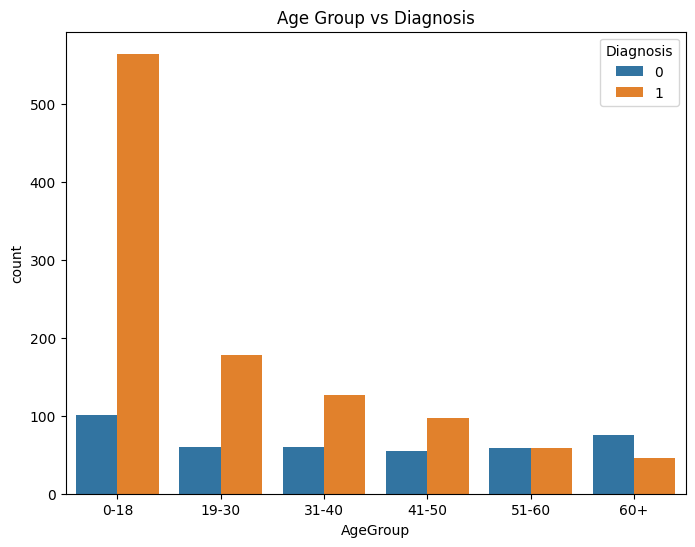

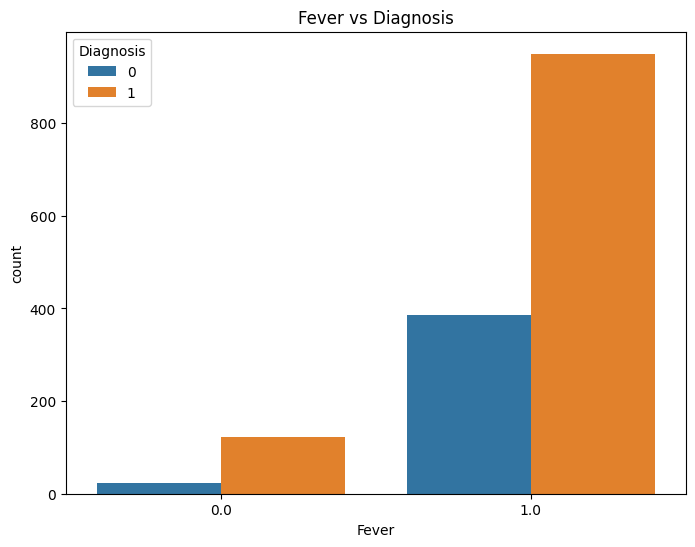

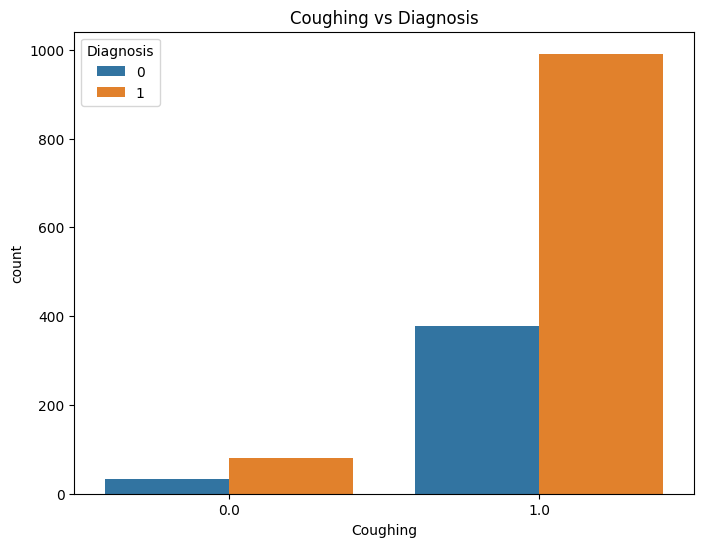

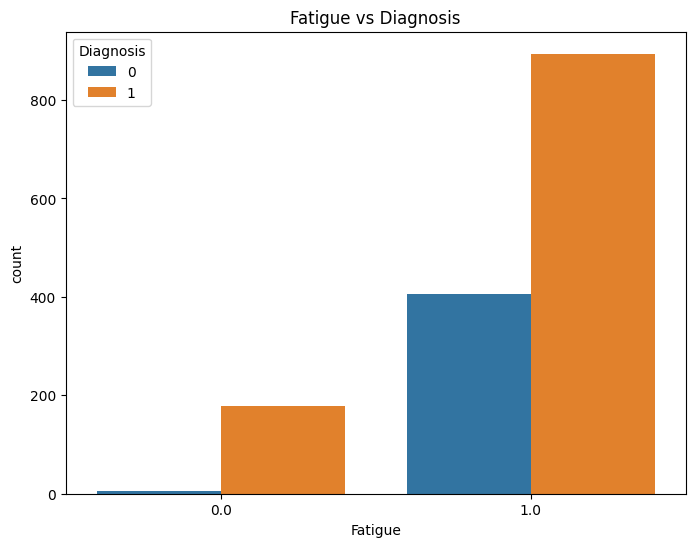

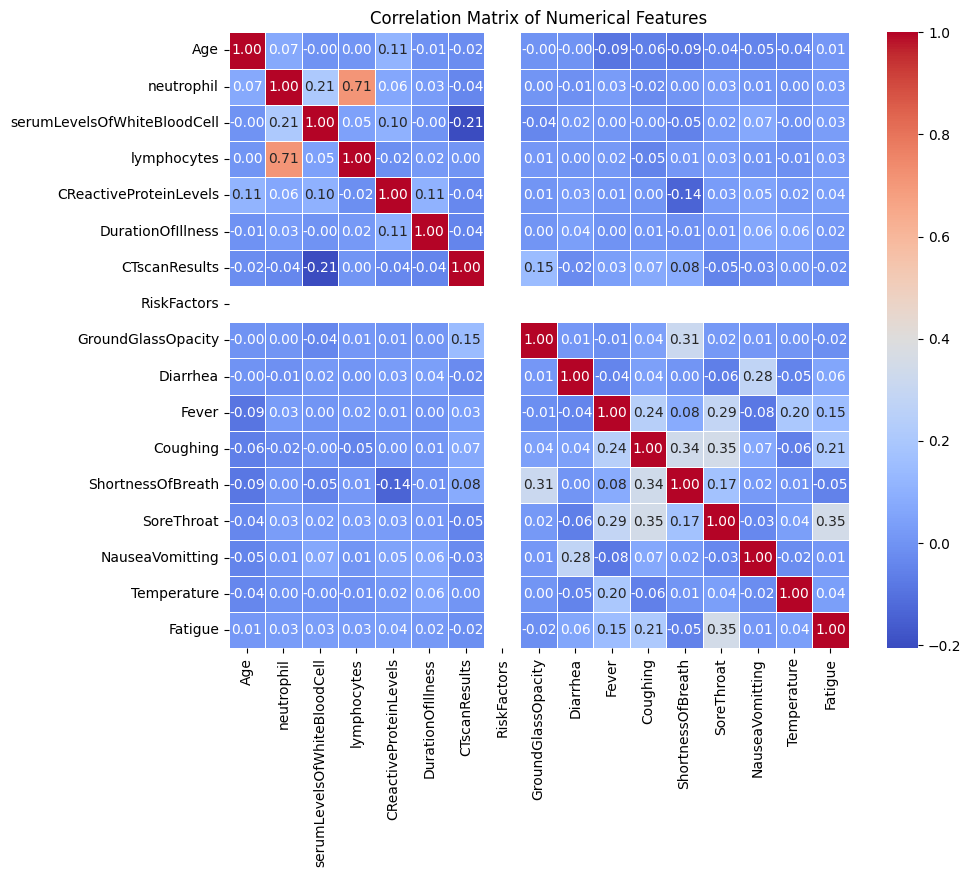

Accuracy: 0.7845
Precision: 0.8122
Recall: 0.8986
F1-Score: 0.8532
AUC: 0.8110


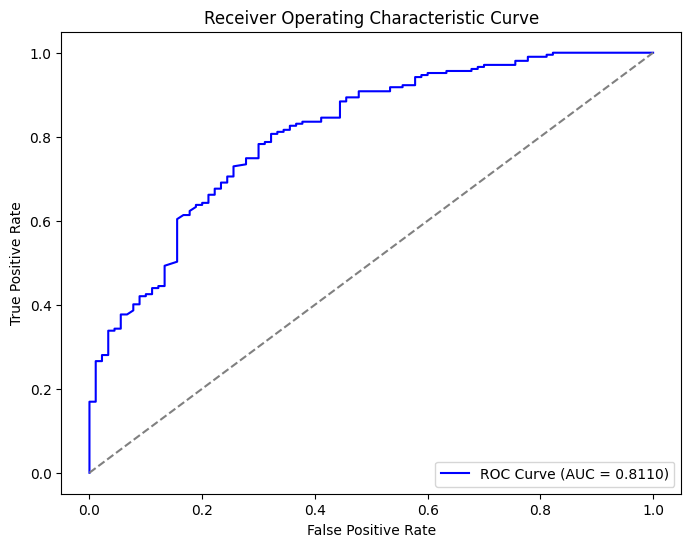

In [36]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'flu.csv'
data = pd.read_csv(file_path)

# Feature Engineering: Convert 'Age' into categorical bins
age_bins = [0, 18, 30, 40, 50, 60, 100]
age_labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '60+']
data['AgeGroup'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)

# Encoding 'Yes'/'No' to 1/0 for categorical columns
yes_no_columns = ['Fever', 'Coughing', 'Fatigue', 'ShortnessOfBreath', 'SoreThroat', 'NauseaVomitting', 'Diarrhea']
for col in yes_no_columns:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

# Encoding categorical columns like 'CTscanResults', 'RiskFactors', 'GroundGlassOpacity'
categorical_columns_to_encode = ['CTscanResults', 'RiskFactors', 'GroundGlassOpacity']
for col in categorical_columns_to_encode:
    data[col] = data[col].map({'Yes': 1, 'No': 0, 'immuno': 1, 'NaN': 0})

# Clean numeric columns by removing non-numeric characters like 'mg/dL'
def clean_numeric_column(col):
    return pd.to_numeric(col.replace(r'[^\d.]+', '', regex=True), errors='coerce')

# Apply the cleaning function to all relevant columns
columns_to_clean = ['neutrophil', 'serumLevelsOfWhiteBloodCell', 'lymphocytes', 'CReactiveProteinLevels', 'DurationOfIllness', 'Temperature']
for col in columns_to_clean:
    data[col] = clean_numeric_column(data[col])

# Imputing missing values
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
numerical_imputer = SimpleImputer(strategy='median')
data[numerical_columns] = numerical_imputer.fit_transform(data[numerical_columns])

categorical_columns = data.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

# Impute missing values for 'AgeGroup'
data['AgeGroup'] = data['AgeGroup'].fillna(data['AgeGroup'].mode()[0])

# Encoding categorical columns
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])
data['Diagnosis'] = label_encoder.fit_transform(data['Diagnosis'])

# Exploratory Data Analysis (EDA)

# Distribution of 'AgeGroup' vs Diagnosis
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='AgeGroup', hue='Diagnosis')
plt.title('Age Group vs Diagnosis')
plt.show()

# Distribution of symptoms vs Diagnosis (Fever, Coughing, Fatigue)
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Fever', hue='Diagnosis')
plt.title('Fever vs Diagnosis')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Coughing', hue='Diagnosis')
plt.title('Coughing vs Diagnosis')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Fatigue', hue='Diagnosis')
plt.title('Fatigue vs Diagnosis')
plt.show()

# Correlation Matrix for Numerical Features
correlation_matrix = data[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Model Training

# Prepare data for model training
X = data.drop(columns=['Diagnosis', 'InitialPCRDiagnosis', 'AgeGroup'])  # Dropping non-numerical target and 'AgeGroup'
y = data['Diagnosis']

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()
